**> Preprocessing**

In [2]:
# =========================
# Cell 1: Setup & Imports
# (safe on Kaggle; defers TF import)
# =========================
import os, sys, gc, json, math, random, textwrap
from pathlib import Path
from collections import defaultdict, Counter
from dataclasses import dataclass

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

# ---- Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

def set_all_seeds(seed: int = SEED):
    """Extend later when we actually import TF/PyTorch."""
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

# ---- Defer TensorFlow import to modeling cells to avoid Kaggle env warnings
def lazy_import_tf():
    """
    Import TensorFlow only when needed (training stage).
    Sets quiet logging to avoid CUDA/cuDNN registration spam.
    Returns tf module or None if import fails.
    """
    os.environ.setdefault("TF_CPP_MIN_LOG_LEVEL", "2")  # quiet logs
    os.environ.setdefault("TF_ENABLE_ONEDNN_OPTS", "0") # stable numerics
    try:
        import tensorflow as tf  # noqa: F401
        return tf
    except Exception as e:
        print("TensorFlow not loaded (will proceed without it):", repr(e))
        return None

print("Python:", sys.version)
print("Pandas:", pd.__version__)
print("TF: deferred import (will load only in modeling cells)")


Python: 3.11.13 (main, Jun  4 2025, 08:57:29) [GCC 11.4.0]
Pandas: 2.2.3
TF: deferred import (will load only in modeling cells)


In [4]:
# =========================
# Cell 2: Config & Paths
# =========================
from pathlib import Path

# Kaggle dataset path (official dataset slug)
INPUT_DIR = Path("/kaggle/input/legalclausedataset")

# Working directories (for generated files and logs)
WORK_DIR  = Path("/kaggle/working")
PAIRS_DIR = WORK_DIR / "pairs"
FIG_DIR   = WORK_DIR / "figures"
LOG_DIR   = WORK_DIR / "logs"

for d in [WORK_DIR, PAIRS_DIR, FIG_DIR, LOG_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ---- Split ratios for train/val/test (no data leakage)
SPLIT_RATIOS = {"train": 0.80, "val": 0.10, "test": 0.10}

# ---- Pair generation configuration
MAX_LEN_CHARS = 5000            # safety cutoff for extremely long clauses
TARGET_POS_PAIRS_PER_CAT = 600  # number of positive pairs to sample per category
NEG_POS_RATIO = 1.0             # 1:1 ratio of negative:positive pairs

# ---- Hard cap on pairs per split (keeps runtime stable)
MAX_PAIRS_PER_SPLIT = {
    "train": 100_000,
    "val"  : 12_000,
    "test" : 12_000,
}

# ---- File matching pattern (395 CSVs)
CSV_GLOB = "*.csv"

print(f" Input directory exists: {INPUT_DIR.exists()}")
print(f" CSV files detected: {len(list(INPUT_DIR.glob(CSV_GLOB)))}")
print(f"Working directory: {WORK_DIR}")


✅ Input directory exists: True
✅ CSV files detected: 395
Working directory: /kaggle/working


In [5]:
# =========================
# Cell 3: Quick Dataset Inspection
# =========================
import pandas as pd
import numpy as np
from pathlib import Path

sample_file = INPUT_DIR / "acceleration.csv"
assert sample_file.exists(), "acceleration.csv not found — please verify dataset path."

# --- Read and inspect
df = pd.read_csv(sample_file)
print(" File:", sample_file.name)
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\nColumn info:")
display(df.info())

# --- Basic sanity checks
print("\nMissing values per column:")
print(df.isna().sum())

# --- Remove duplicates for clean stats (don’t modify source files yet)
df_unique = df.drop_duplicates(subset="clause_text")
print(f"\nUnique clauses: {len(df_unique)} / {len(df)}")

# --- Text length distribution
df_unique["char_len"] = df_unique["clause_text"].astype(str).str.len()
df_unique["word_len"] = df_unique["clause_text"].astype(str).str.split().str.len()

print("\nClause length (characters):")
print(df_unique["char_len"].describe(percentiles=[.1, .5, .9, .95]))

print("\nClause length (words):")
print(df_unique["word_len"].describe(percentiles=[.1, .5, .9, .95]))

# --- Sample examples
print("\nRandom 3 sample clauses:")
for t in df_unique["clause_text"].sample(3, random_state=SEED):
    print("-" * 100)
    print(textwrap.shorten(t, width=400, placeholder=" ..."))

# --- Preview few more random category files (for variety)
import random
other_files = random.sample(sorted(list(INPUT_DIR.glob("*.csv"))), 5)
print("\nOther categories to confirm schema consistency:")
for f in other_files:
    tmp = pd.read_csv(f, nrows=2)
    print(f"{f.name:40s} -> shape {tmp.shape}, columns {tmp.columns.tolist()}")


📄 File: acceleration.csv
Shape: (350, 2)
Columns: ['clause_text', 'clause_type']

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   clause_text  350 non-null    object
 1   clause_type  350 non-null    object
dtypes: object(2)
memory usage: 5.6+ KB


None


Missing values per column:
clause_text    0
clause_type    0
dtype: int64

Unique clauses: 350 / 350

Clause length (characters):
count     350.000000
mean      727.177143
std       608.505579
min        86.000000
10%       186.500000
50%       487.500000
90%      1714.300000
95%      1983.600000
max      2517.000000
Name: char_len, dtype: float64

Clause length (words):
count    350.000000
mean     119.862857
std      101.826970
min        4.000000
10%       30.000000
50%       76.500000
90%      292.200000
95%      328.200000
max      437.000000
Name: word_len, dtype: float64

Random 3 sample clauses:
----------------------------------------------------------------------------------------------------
Acceleration. The Agent may, and upon the request of the Required Lenders shall, accelerate the applicable Loan, after the occurrence and during the continuance of an Event of Default. Upon such an acceleration, all principal, accrued interest and costs and expenses shall be due and pay

In [6]:
# ==========================================
# Cell 4: Cleaning functions (legal-friendly)
# ==========================================
import re

# Precompiled regexes
WS_RE       = re.compile(r"\s+")
CONTROL_RE  = re.compile(r"[\x00-\x08\x0B-\x0C\x0E-\x1F]")
DASHES_RE   = re.compile(r"[‐-‒–—―]+")   # various unicode dashes → single hyphen
NBSP_RE     = re.compile(r"\u00A0")      # non-breaking space

# Configurable max char length from Cell 2
MAX_LEN_CHARS = MAX_LEN_CHARS if 'MAX_LEN_CHARS' in globals() else 5000

def clean_text(s: str) -> str:
    """
    Minimal, lossless cleaning suitable for legal clauses:
      - Normalize quotes/dashes/spaces
      - Remove control chars
      - Collapse whitespace
      - Preserve punctuation and casing (legal meaning!)
    """
    if not isinstance(s, str):
        return ""
    # Normalize common unicode punctuation to ASCII equivalents
    s = (s.replace("\u201c", '"').replace("\u201d", '"')
           .replace("\u2019", "'").replace("\u2018", "'"))
    # Normalize dashes and spaces
    s = DASHES_RE.sub("-", s)
    s = NBSP_RE.sub(" ", s)
    # Strip control characters
    s = CONTROL_RE.sub(" ", s)
    # Collapse whitespace
    s = WS_RE.sub(" ", s).strip()
    return s

def truncate_text(s: str, max_chars: int = MAX_LEN_CHARS) -> str:
    """Hard truncate extremely long rows (safety)."""
    if not isinstance(s, str):
        return ""
    return s if len(s) <= max_chars else s[:max_chars]

# Quick self-test (optional)
_test = '“Acceleration” — upon Event-of-Default…\u00A0 \u0007 OK?'
print("Before:", _test)
print("After :", clean_text(_test))


Before: “Acceleration” — upon Event-of-Default…   OK?
After : "Acceleration" - upon Event-of-Default… OK?


In [7]:
# ==========================================================
# Cell 5: Read and Combine All CSV Files (clean + tag + ID)
# ==========================================================
all_rows = []
csv_files = sorted(INPUT_DIR.glob("*.csv"))
print(f" Total CSV files detected: {len(csv_files)}")

for path in tqdm(csv_files, desc="Reading & cleaning CSVs"):
    try:
        df = pd.read_csv(path)
        # ensure expected columns
        if "clause_text" not in df.columns or "clause_type" not in df.columns:
            continue
        # keep only relevant columns
        df = df[["clause_text", "clause_type"]].copy()
        # apply cleaning + truncation
        df["clause_text"] = (
            df["clause_text"].astype(str)
            .map(clean_text)
            .map(lambda x: truncate_text(x, MAX_LEN_CHARS))
        )
        # derive category from filename (e.g., acceleration.csv → "acceleration")
        df["category"] = path.stem
        # add a numeric row_id within the category
        df["row_id"] = np.arange(len(df))
        # global unique identifier
        df["clause_id"] = df["category"] + "::" + df["row_id"].astype(str)
        all_rows.append(df)
    except Exception as e:
        print(f" Failed to read {path.name}: {e}")

# combine everything
clauses = pd.concat(all_rows, ignore_index=True)

# drop empties & reset
clauses = clauses.dropna(subset=["clause_text"]).reset_index(drop=True)
clauses = clauses[clauses["clause_text"].str.strip().ne("")]
print(f" Combined dataset: {len(clauses):,} total clauses")

# quick stats
print(f"Unique categories: {clauses['category'].nunique()}")
display(clauses.head(5))

# per-category counts
cat_counts = clauses["category"].value_counts().reset_index()
cat_counts.columns = ["category", "num_clauses"]
print("\nTop 10 categories by number of clauses:")
display(cat_counts.head(10))


📁 Total CSV files detected: 395


Reading & cleaning CSVs:   0%|          | 0/395 [00:00<?, ?it/s]

✅ Combined dataset: 150,881 total clauses
Unique categories: 395


,clause_text,clause_type,category,row_id,clause_id
0,Absence of Certain Changes or Events. Except a...,absence-of-certain-changes-or-events,absence-of-certain-changes-or-events,0,absence-of-certain-changes-or-events::0
1,Absence of Certain Changes or Events. Since Ma...,absence-of-certain-changes-or-events,absence-of-certain-changes-or-events,1,absence-of-certain-changes-or-events::1
2,Absence of Certain Changes or Events. (a) Sinc...,absence-of-certain-changes-or-events,absence-of-certain-changes-or-events,2,absence-of-certain-changes-or-events::2
3,Absence of Certain Changes or Events. Since th...,absence-of-certain-changes-or-events,absence-of-certain-changes-or-events,3,absence-of-certain-changes-or-events::3
4,Absence of Certain Changes or Events. Except a...,absence-of-certain-changes-or-events,absence-of-certain-changes-or-events,4,absence-of-certain-changes-or-events::4



Top 10 categories by number of clauses:


,category,num_clauses
0,time-of-essence,630
1,time-of-the-essence,620
2,capitalized-terms,590
3,definitions-and-interpretation,590
4,captions,580
5,headings,570
6,section-headings,570
7,now-therefore,570
8,exhibits,570
9,definitions,560


In [8]:
# =======================================================================
# Cell 6: Split clauses into train/val/test (leakage-safe per category)
# =======================================================================
rng = np.random.default_rng(SEED)
split_col = pd.Series(index=clauses.index, dtype="object")

for cat, g in clauses.groupby("category", sort=False):
    idx = g.index.to_numpy()
    rng.shuffle(idx)
    n = len(idx)
    n_train = int(n * SPLIT_RATIOS["train"])
    n_val   = int(n * SPLIT_RATIOS["val"])
    # remainder goes to test
    train_idx = idx[:n_train]
    val_idx   = idx[n_train:n_train+n_val]
    test_idx  = idx[n_train+n_val:]

    split_col.loc[train_idx] = "train"
    split_col.loc[val_idx]   = "val"
    split_col.loc[test_idx]  = "test"

clauses["split"] = split_col.values

# ---- Quick sanity summary
print("Split counts (rows):")
print(clauses["split"].value_counts())

# Save a snapshot for reference (optional)
clauses_path = WORK_DIR / "clauses_with_split.parquet"
clauses.to_parquet(clauses_path, index=False)
print("Saved:", clauses_path)

# Peek
display(clauses.sample(5, random_state=SEED))


Split counts (rows):
split
train    120702
test      15095
val       15084
Name: count, dtype: int64
Saved: /kaggle/working/clauses_with_split.parquet


,clause_text,clause_type,category,row_id,clause_id,split
24777,Compliance. The Company shall comply in all ma...,compliance,compliance,124,compliance::124,train
30485,Cooperation. Following the termination of the ...,cooperation,cooperation,62,cooperation::62,train
102783,Permits. Prior to the commencement of the Work...,permits,permits,300,permits::300,train
74512,Liability. (a) The duties and obligations of t...,liability,liability,266,liability::266,train
121124,Right of Setoff. To the extent permitted by ap...,right-of-setoff,right-of-setoff,281,right-of-setoff::281,train


In [10]:
# =======================================================================
# Cell 7: Pair generation helpers (positives & negatives per split)
# =======================================================================
from dataclasses import dataclass
from typing import Dict, List, Tuple

@dataclass
class PairConfig:
    target_pos_per_cat: int = TARGET_POS_PAIRS_PER_CAT
    neg_pos_ratio: float = NEG_POS_RATIO
    max_pairs_per_split: Dict[str, int] = None

PAIR_CFG = PairConfig(
    target_pos_per_cat=TARGET_POS_PAIRS_PER_CAT,
    neg_pos_ratio=NEG_POS_RATIO,
    max_pairs_per_split=MAX_PAIRS_PER_SPLIT
)

rng_global = np.random.default_rng(SEED)

def _sample_unique_pairs(indices: List[int], target: int, seed: int = SEED) -> List[Tuple[int,int]]:
    """
    Efficiently sample up to `target` unique unordered pairs i<j from `indices`.
    Avoids O(n^2) combinations by random sampling.
    """
    if len(indices) < 2 or target <= 0:
        return []
    rng = np.random.default_rng(seed)
    idx = np.array(indices, dtype=np.int64)
    pairs = set()
    # adaptive tries based on target and pool size
    tries = max(50, min(2000, target * 10))
    n = len(idx)
    for _ in range(tries):
        a = rng.choice(idx, size=min(n, 1024), replace=False)
        b = rng.choice(idx, size=min(n, 1024), replace=False)
        # enforce unordered uniqueness i<j
        mask = a < b
        for ai, bi in zip(a[mask], b[mask]):
            pairs.add((int(ai), int(bi)))
            if len(pairs) >= target:
                break
        if len(pairs) >= target:
            break
    # return as list (already unique)
    return list(pairs)

def generate_pairs_for_split(clauses_split: pd.DataFrame, split_name: str, cfg: PairConfig) -> pd.DataFrame:
    """
    Create labeled clause pairs within a given split:
      - Positives: within SAME category
      - Negatives: ACROSS different categories
    Balanced by cfg.neg_pos_ratio and capped by cfg.max_pairs_per_split[split_name].
    """
    # Build per-category indices
    cat_groups = {cat: g.index.tolist() for cat, g in clauses_split.groupby("category", sort=False)}
    categories = list(cat_groups.keys())

    # ---------- POSITIVE PAIRS ----------
    pos_records = []
    for cat, idxs in tqdm(cat_groups.items(), desc=f"[{split_name}] positives"):
        if len(idxs) < 2:
            continue
        # target positives per category, bounded by possible pairs
        max_possible = (len(idxs) * (len(idxs)-1)) // 2
        target = min(cfg.target_pos_per_cat, max_possible)
        if target <= 0:
            continue
        cand_pairs = _sample_unique_pairs(idxs, target=target, seed=SEED)
        for i, j in cand_pairs:
            a = clauses_split.loc[i]
            b = clauses_split.loc[j]
            # safety: enforce different clause ids
            if a["clause_id"] == b["clause_id"]:
                continue
            pos_records.append({
                "a_id": a["clause_id"], "b_id": b["clause_id"],
                "a_text": a["clause_text"], "b_text": b["clause_text"],
                "a_cat": a["category"], "b_cat": b["category"],
                "label": 1
            })

    # ---------- NEGATIVE PAIRS ----------
    # target number of negatives based on collected positives
    target_negs = int(len(pos_records) * cfg.neg_pos_ratio)
    neg_records = []
    if target_negs > 0 and len(categories) >= 2:
        rng = np.random.default_rng(SEED)
        cats = categories
        # Precache arrays for speed
        cat_idx_map = {c: np.array(v, dtype=np.int64) for c, v in cat_groups.items()}
        # create shuffled list of cross-category pairs
        cat_pairs = [(cats[i], cats[j]) for i in range(len(cats)) for j in range(i+1, len(cats))]
        rng.shuffle(cat_pairs)

        # sample negatives until target reached (bounded loops)
        for ca, cb in tqdm(cat_pairs, total=len(cat_pairs), desc=f"[{split_name}] negatives (by category)"):
            ia = cat_idx_map[ca]
            ib = cat_idx_map[cb]
            if len(ia) == 0 or len(ib) == 0:
                continue
            # small random batches from each category to create many cross pairs fast
            take_a = min(len(ia), 16)
            take_b = min(len(ib), 16)
            sa = rng.choice(ia, size=take_a, replace=False)
            sb = rng.choice(ib, size=take_b, replace=False)
            for a_i in sa:
                for b_i in sb:
                    a = clauses_split.loc[int(a_i)]
                    b = clauses_split.loc[int(b_i)]
                    if a["clause_id"] == b["clause_id"]:
                        continue
                    neg_records.append({
                        "a_id": a["clause_id"], "b_id": b["clause_id"],
                        "a_text": a["clause_text"], "b_text": b["clause_text"],
                        "a_cat": a["category"], "b_cat": b["category"],
                        "label": 0
                    })
                    if len(neg_records) >= target_negs:
                        break
                if len(neg_records) >= target_negs:
                    break
            if len(neg_records) >= target_negs:
                break

    # ---------- MERGE & CAP ----------
    pairs = pos_records + neg_records
    rng_global.shuffle(pairs)  # global shuffle
    max_allowed = cfg.max_pairs_per_split.get(split_name, None)
    if max_allowed is not None and len(pairs) > max_allowed:
        pairs = pairs[:max_allowed]

    pairs_df = pd.DataFrame(pairs, columns=[
        "a_id","b_id","a_text","b_text","a_cat","b_cat","label"
    ])
    return pairs_df


In [11]:
# ==========================================================
# Cell 8: Build pairs for each split and save to /working
# ==========================================================
import time, json

start = time.time()

pairs_train = generate_pairs_for_split(
    clauses[clauses["split"]=="train"].copy(), "train", PAIR_CFG
)
pairs_val = generate_pairs_for_split(
    clauses[clauses["split"]=="val"].copy(), "val", PAIR_CFG
)
pairs_test = generate_pairs_for_split(
    clauses[clauses["split"]=="test"].copy(), "test", PAIR_CFG
)

# Save CSVs
paths = {}
for name, dfp in [("train", pairs_train), ("val", pairs_val), ("test", pairs_test)]:
    out_path = PAIRS_DIR / f"pairs_{name}.csv"
    dfp.to_csv(out_path, index=False)
    paths[name] = str(out_path)
    print(f" Saved {name} pairs:", out_path, f"({len(dfp):,} rows)")

# Basic stats for report
def stats(dfp):
    n = len(dfp)
    pos = int((dfp["label"]==1).sum())
    neg = int((dfp["label"]==0).sum())
    pos_frac = float(pos / n) if n else 0.0
    cats = (set(dfp["a_cat"].unique()) | set(dfp["b_cat"].unique()))
    return {
        "n_pairs": n, "pos": pos, "neg": neg, "pos_frac": pos_frac,
        "unique_categories_in_pairs": len(cats)
    }

pairs_stats = {
    "train": stats(pairs_train),
    "val": stats(pairs_val),
    "test": stats(pairs_test),
    "config": {
        "TARGET_POS_PAIRS_PER_CAT": TARGET_POS_PAIRS_PER_CAT,
        "NEG_POS_RATIO": NEG_POS_RATIO,
        "MAX_PAIRS_PER_SPLIT": MAX_PAIRS_PER_SPLIT,
        "SPLIT_RATIOS": SPLIT_RATIOS
    },
    "paths": paths
}

with open(LOG_DIR / "pair_generation_stats.json", "w") as f:
    json.dump(pairs_stats, f, indent=2)

elapsed = time.time() - start
print("\n=== Pair Generation Summary ===")
print(json.dumps(pairs_stats, indent=2))
print(f" Elapsed: {elapsed:.1f}s")

# Quick peek
display(pairs_train.head(3))
display(pairs_val.head(3))
display(pairs_test.head(3))


[train] positives:   0%|          | 0/395 [00:00<?, ?it/s]

[train] negatives (by category):   0%|          | 0/77815 [00:00<?, ?it/s]

[val] positives:   0%|          | 0/395 [00:00<?, ?it/s]

[val] negatives (by category):   0%|          | 0/77815 [00:00<?, ?it/s]

[test] positives:   0%|          | 0/395 [00:00<?, ?it/s]

[test] negatives (by category):   0%|          | 0/77815 [00:00<?, ?it/s]

✅ Saved train pairs: /kaggle/working/pairs/pairs_train.csv (100,000 rows)
✅ Saved val pairs: /kaggle/working/pairs/pairs_val.csv (12,000 rows)
✅ Saved test pairs: /kaggle/working/pairs/pairs_test.csv (12,000 rows)

=== Pair Generation Summary ===
{
  "train": {
    "n_pairs": 100000,
    "pos": 49945,
    "neg": 50055,
    "pos_frac": 0.49945,
    "unique_categories_in_pairs": 395
  },
  "val": {
    "n_pairs": 12000,
    "pos": 6168,
    "neg": 5832,
    "pos_frac": 0.514,
    "unique_categories_in_pairs": 394
  },
  "test": {
    "n_pairs": 12000,
    "pos": 6021,
    "neg": 5979,
    "pos_frac": 0.50175,
    "unique_categories_in_pairs": 395
  },
  "config": {
    "TARGET_POS_PAIRS_PER_CAT": 600,
    "NEG_POS_RATIO": 1.0,
    "MAX_PAIRS_PER_SPLIT": {
      "train": 100000,
      "val": 12000,
      "test": 12000
    },
    "SPLIT_RATIOS": {
      "train": 0.8,
      "val": 0.1,
      "test": 0.1
    }
  },
  "paths": {
    "train": "/kaggle/working/pairs/pairs_train.csv",
    "val":

,a_id,b_id,a_text,b_text,a_cat,b_cat,label
0,amendments-etc::11,reimbursement-of-expenses::143,"Amendments, Etc. No amendment or waiver of any...",Reimbursement of Expenses. During the Employme...,amendments-etc,reimbursement-of-expenses,0
1,reports::126,severability::104,"Reports. The Directors, including the Independ...",Severability. If any portion or provision of t...,reports,severability,0
2,additional-agreements::47,additional-agreements::49,Additional Agreements. (a) Each of the Parties...,Additional Agreements. In addition to the fore...,additional-agreements,additional-agreements,1


,a_id,b_id,a_text,b_text,a_cat,b_cat,label
0,limitation-of-liability::89,restrictive-covenants::64,Limitation of Liability. The Manager and Advis...,Restrictive Covenants. (a) Seller covenants th...,limitation-of-liability,restrictive-covenants,0
1,restrictive-covenants::67,restrictive-covenants::280,Restrictive Covenants. During the Restricted P...,Restrictive Covenants. Executive acknowledges ...,restrictive-covenants,restrictive-covenants,1
2,certain-defined-terms::226,certain-defined-terms::305,Certain Defined Terms. As used in this Section...,Certain Defined Terms. For purposes of this Ag...,certain-defined-terms,certain-defined-terms,1


,a_id,b_id,a_text,b_text,a_cat,b_cat,label
0,reimbursement::11,reimbursement::148,Reimbursement. If an Issuing Bank shall make a...,Reimbursement. (a) If the Issuing Lender shall...,reimbursement,reimbursement,1
1,financial-information::132,financial-information::222,Financial Information. Lessee will furnish to ...,Financial Information. From and after the date...,financial-information,financial-information,1
2,termination-without-cause::73,termination-without-cause::339,Termination Without Cause. The Company may ter...,Termination Without Cause. If AB terminates th...,termination-without-cause,termination-without-cause,1


In [12]:
# ===========================================
# Cell 9: Sanity checks for pairs integrity
# ===========================================

# 1  Clause-ID overlap check across splits
ids_train = set(clauses.loc[clauses["split"]=="train","clause_id"])
ids_val   = set(clauses.loc[clauses["split"]=="val","clause_id"])
ids_test  = set(clauses.loc[clauses["split"]=="test","clause_id"])

def has_overlap(a, b): return len(a & b) > 0

print(" Leakage check (should all be False):")
print("train ∩ val :", has_overlap(ids_train, ids_val))
print("train ∩ test:", has_overlap(ids_train, ids_test))
print("val ∩ test  :", has_overlap(ids_val, ids_test))

# 2  Verify every pair belongs to its own split
def check_split(df_pairs, split_name, valid_ids):
    return df_pairs["a_id"].isin(valid_ids).all() and df_pairs["b_id"].isin(valid_ids).all()

print("\nSplit membership check:")
print("train pairs valid:", check_split(pairs_train, "train", ids_train))
print("val   pairs valid:", check_split(pairs_val,   "val",   ids_val))
print("test  pairs valid:", check_split(pairs_test,  "test",  ids_test))

# 3  Label balance
for name, df in [("train", pairs_train), ("val", pairs_val), ("test", pairs_test)]:
    vc = df["label"].value_counts(normalize=True).mul(100).round(2).to_dict()
    print(f"{name:<6} → {len(df):>7,} pairs | label %:", vc)

# 4  Text length stats (decide max_len for tokenizer)
def len_stats(series):
    arr = series.astype(str).str.len()
    return {
        "min": int(arr.min()),
        "median": float(arr.median()),
        "p90": float(arr.quantile(0.9)),
        "p95": float(arr.quantile(0.95)),
        "max": int(arr.max())
    }

lens_a = len_stats(pairs_train["a_text"])
lens_b = len_stats(pairs_train["b_text"])
print("\nLength stats (characters) — a_text:", lens_a)
print("Length stats (characters) — b_text:", lens_b)

# 5  Save qualitative sample for report
sample_pairs = pd.concat([
    pairs_train.sample(5, random_state=SEED),
    pairs_val.sample(5, random_state=SEED),
    pairs_test.sample(5, random_state=SEED)
], ignore_index=True)
qual_path = WORK_DIR / "sample_pairs_preview.csv"
sample_pairs.to_csv(qual_path, index=False)
print("\n Saved small qualitative sample to:", qual_path)
display(sample_pairs.head(3))


🔒 Leakage check (should all be False):
train ∩ val : False
train ∩ test: False
val ∩ test  : False

Split membership check:
train pairs valid: True
val   pairs valid: True
test  pairs valid: True
train  → 100,000 pairs | label %: {0: 50.06, 1: 49.94}
val    →  12,000 pairs | label %: {1: 51.4, 0: 48.6}
test   →  12,000 pairs | label %: {1: 50.18, 0: 49.82}

Length stats (characters) — a_text: {'min': 15, 'median': 463.0, 'p90': 1516.0, 'p95': 2081.0, 'max': 2546}
Length stats (characters) — b_text: {'min': 15, 'median': 450.0, 'p90': 1416.0, 'p95': 1928.0, 'max': 2546}

✅ Saved small qualitative sample to: /kaggle/working/sample_pairs_preview.csv


,a_id,b_id,a_text,b_text,a_cat,b_cat,label
0,general-provisions::225,organization::253,General Provisions. 1. All obligations of the ...,Organization. Meetings of the Board shall be p...,general-provisions,organization,0
1,fees::249,further-assurances::44,Fees. (a) The Borrower agrees to pay to the Ad...,Further Assurances. Each party hereby agrees t...,fees,further-assurances,0
2,parties-in-interest::11,parties-in-interest::258,Parties in Interest. This Agreement shall inur...,Parties in Interest. Except for the indemnific...,parties-in-interest,parties-in-interest,1


In [13]:
# =========================
# Cell 10: Tokenization (Keras TextVectorization)
# =========================
tf = lazy_import_tf()
assert tf is not None, "TensorFlow failed to import. Please re-run the notebook or restart the session."

set_all_seeds(SEED)

from tensorflow.keras.layers import TextVectorization

# ---- Tokenizer hyperparameters (adjustable later if needed)
MAX_TOKENS = 40_000    # vocabulary size cap
MAX_LEN    = 200       # sequence length (tokens)

# ---- Prepare train-only corpus (no leakage)
train_texts = pd.concat(
    [pairs_train["a_text"], pairs_train["b_text"]],
    ignore_index=True
).astype(str)

# Rough estimate of truncation rate BEFORE vectorization (whitespace token count)
train_word_lens = train_texts.str.split().str.len()
over_len_pct = (train_word_lens > MAX_LEN).mean() * 100
print(f"Estimated % of train texts > {MAX_LEN} tokens (pre-vectorization): {over_len_pct:.2f}%")

# ---- Build vectorizer (legal-friendly: preserve case & punctuation)
vectorizer = TextVectorization(
    max_tokens=MAX_TOKENS,
    output_mode="int",
    output_sequence_length=MAX_LEN,
    standardize=None,       # DO NOT lowercase/strip punctuation
    split="whitespace"      # simple, deterministic split
)

# Adapt on train texts via tf.data for memory efficiency
batch_size = 1024
ds_adapt = tf.data.Dataset.from_tensor_slices(train_texts.values).batch(batch_size)
vectorizer.adapt(ds_adapt)
vocab = vectorizer.get_vocabulary()
print(f"Vocab size (including OOV/index 0): {len(vocab):,}")

# ---- Save tokenizer artifacts for reproducibility
# 1) Vocabulary file (for report/reuse)
vocab_path = WORK_DIR / "tokenizer_vocab.txt"
with open(vocab_path, "w", encoding="utf-8") as f:
    for tok in vocab:
        f.write(tok + "\n")
print("Saved vocabulary to:", vocab_path)

# 2) Config JSON
tok_cfg = {
    "MAX_TOKENS": MAX_TOKENS,
    "MAX_LEN": MAX_LEN,
    "standardize": None,
    "split": "whitespace",
    "seed": SEED
}
import json
cfg_path = WORK_DIR / "tokenizer_config.json"
with open(cfg_path, "w") as f:
    json.dump(tok_cfg, f, indent=2)
print("Saved tokenizer config to:", cfg_path)

# ---- Quick sanity: vectorize a tiny sample
sample_a = pairs_train["a_text"].iloc[:3].tolist()
sample_ids = vectorizer(tf.constant(sample_a))
print("Vectorized sample shape:", sample_ids.shape)
print("First row (first 20 token-ids):", sample_ids[0][:20].numpy())


Estimated % of train texts > 200 tokens (pre-vectorization): 13.50%


I0000 00:00:1762720879.576593      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762720879.577336      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Vocab size (including OOV/index 0): 40,000
Saved vocabulary to: /kaggle/working/tokenizer_vocab.txt
Saved tokenizer config to: /kaggle/working/tokenizer_config.json
Vectorized sample shape: (3, 200)
First row (first 20 token-ids): [2810 1860  117  377    4  168    3    7  110    3   14 1403  162  127
    6    7 3254   11    7  351]


**> BASELINE 1**

In [14]:
# =========================
# Cell 11: Siamese BiLSTM Model Definition
# =========================
from tensorflow.keras import layers, models, regularizers, backend as K

def build_siamese_bilstm(
    vocab_size=MAX_TOKENS,
    embed_dim=128,
    lstm_units=128,
    max_len=MAX_LEN,
    dropout_rate=0.3
):
    """
    Baseline 1 – Siamese BiLSTM architecture
    ---------------------------------------------------
    Input: two legal clauses (A, B)
    Shared encoder:
        Embedding → BiLSTM → GlobalMaxPool → Dense
    Merge head:
        |u − v| , u ∘ v (concat) → Dense → Sigmoid
    """
    # Shared encoder branch
    inp = layers.Input(shape=(max_len,), name="clause_input")
    x = layers.Embedding(vocab_size, embed_dim, name="embedding")(inp)
    x = layers.Bidirectional(layers.LSTM(lstm_units, return_sequences=True))(x)
    x = layers.GlobalMaxPooling1D()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(128, activation="relu")(x)
    encoder = models.Model(inp, x, name="shared_encoder")

    # Two inputs (A & B)
    inp_a = layers.Input(shape=(max_len,), name="input_a")
    inp_b = layers.Input(shape=(max_len,), name="input_b")
    vec_a = encoder(inp_a)
    vec_b = encoder(inp_b)

    # Similarity features
    diff = layers.Lambda(lambda t: K.abs(t[0] - t[1]))([vec_a, vec_b])
    mult = layers.Multiply()([vec_a, vec_b])
    merged = layers.Concatenate()([diff, mult])

    # Classification head
    x = layers.Dense(128, activation="relu")(merged)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    model = models.Model(inputs=[inp_a, inp_b], outputs=out, name="Siamese_BiLSTM")
    model.compile(
        loss="binary_crossentropy",
        optimizer="adam",
        metrics=["accuracy"]
    )
    return model

# ---- Build & summarize
bilstm_model = build_siamese_bilstm()
bilstm_model.summary(line_length=120, show_trainable=True)


Model: "Siamese_BiLSTM"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━
┃ Layer (type)                  ┃ Output Shape              ┃          Param # ┃ Connected to              ┃ Traina
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━
│ input_a (InputLayer)          │ (None, 200)               │                0 │ -                         │     - 
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ input_b (InputLayer)          │ (None, 200)               │                0 │ -                         │     - 
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ shared_encoder (Functional)   │ (None, 128)               │        5,416,064 │ input_a[0][0],            │     Y 
│                               │                           │                  │ input_b[0][0]             │       
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ lambda (Lambda)               │ (None, 128)               │                0 │ shared_encoder[0][0],     │     - 
│                               │                           │                  │ shared_encoder[1][0]      │       
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ multiply (Multiply)           │ (None, 128)               │                0 │ shared_encoder[0][0],     │     - 
│                               │                           │                  │ shared_encoder[1][0]      │       
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ concatenate (Concatenate)     │ (None, 256)               │                0 │ lambda[0][0],             │     - 
│                               │                           │                  │ multiply[0][0]            │       
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ dense_1 (Dense)               │ (None, 128)               │           32,896 │ concatenate[0][0]         │     Y 
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ dropout_1 (Dropout)           │ (None, 128)               │                0 │ dense_1[0][0]             │     - 
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ dense_2 (Dense)               │ (None, 64)                │            8,256 │ dropout_1[0][0]           │     Y 
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ dense_3 (Dense)               │ (None, 1)                 │               65 │ dense_2[0][0]             │     Y 
└───────────────────────────────┴───────────────────────────┴──────────────────┴───────────────────────────┴───────

 Total params: 5,457,281 (20.82 MB)

 Trainable params: 5,457,281 (20.82 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# =========================
# Cell 12: Train Siamese BiLSTM 
# =========================
import time
tf = lazy_import_tf()
assert tf is not None, "TensorFlow not available."

set_all_seeds(SEED)

# ---------- Vectorize pairs (train & val) ----------
def vectorize_side(text_series):
    return vectorizer(tf.constant(text_series.astype(str).values)).numpy()

print("Vectorizing train pairs...")
Xa_tr = vectorize_side(pairs_train["a_text"])
Xb_tr = vectorize_side(pairs_train["b_text"])
y_tr  = pairs_train["label"].astype("float32").values

print("Vectorizing val pairs...")
Xa_va = vectorize_side(pairs_val["a_text"])
Xb_va = vectorize_side(pairs_val["b_text"])
y_va  = pairs_val["label"].astype("float32").values

print("Shapes:",
      "\n  Xa_tr", Xa_tr.shape, "Xb_tr", Xb_tr.shape, "y_tr", y_tr.shape,
      "\n  Xa_va", Xa_va.shape, "Xb_va", Xb_va.shape, "y_va", y_va.shape)

# ---------- Build tf.data pipelines ----------
BATCH_SIZE = 256

train_ds = tf.data.Dataset.from_tensor_slices(((Xa_tr, Xb_tr), y_tr))\
    .shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)\
    .batch(BATCH_SIZE)\
    .prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(((Xa_va, Xb_va), y_va))\
    .batch(BATCH_SIZE)\
    .prefetch(tf.data.AUTOTUNE)

# ---------- Build/fresh model ----------
bilstm_model = build_siamese_bilstm(
    vocab_size=min(MAX_TOKENS, len(vectorizer.get_vocabulary())),
    embed_dim=128,
    lstm_units=128,
    max_len=MAX_LEN,
    dropout_rate=0.30
)

# Add useful metrics (ROC-AUC + PR-AUC)
bilstm_model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc", curve="ROC"),
        tf.keras.metrics.AUC(name="aupr", curve="PR"),
    ],
)

# ---------- Callbacks ----------
ckpt_path = WORK_DIR / "bilstm_best.keras"
csv_log   = WORK_DIR / "bilstm_history.csv"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(ckpt_path),
        save_best_only=True,
        monitor="val_auc",
        mode="max",
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc",
        mode="max",
        factor=0.5,
        patience=1,
        min_lr=1e-5,
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger(str(csv_log))
]

# ---------- Train ----------
EPOCHS = 12
print("Starting training...")
t0 = time.time()
history = bilstm_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)
t_train = time.time() - t0
print(f"Training time: {t_train/60:.1f} min")

# Save final model
final_model_path = WORK_DIR / "bilstm_final.keras"
bilstm_model.save(str(final_model_path))
print("Saved best weights to:", ckpt_path)
print("Saved final model to :", final_model_path)

# Quick summary of final epoch metrics
hist = history.history
print("\nFinal epoch metrics:")
for k in ["loss","accuracy","auc","aupr","val_loss","val_accuracy","val_auc","val_aupr"]:
    if k in hist:
        print(f"  {k:>12s}: {hist[k][-1]:.4f}")


Vectorizing train pairs...
Vectorizing val pairs...
Shapes: 
  Xa_tr (100000, 200) Xb_tr (100000, 200) y_tr (100000,) 
  Xa_va (12000, 200) Xb_va (12000, 200) y_va (12000,)
Starting training...
Epoch 1/12


I0000 00:00:1762721229.155705     124 cuda_dnn.cc:529] Loaded cuDNN version 90300


391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6240 - auc: 0.6856 - aupr: 0.6910 - loss: 0.5593
Epoch 1: val_auc improved from -inf to 0.99750, saving model to /kaggle/working/bilstm_best.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 54s 117ms/step - accuracy: 0.6244 - auc: 0.6862 - aupr: 0.6916 - loss: 0.5587 - val_accuracy: 0.9941 - val_auc: 0.9975 - val_aupr: 0.9981 - val_loss: 0.0313 - learning_rate: 0.0010
Epoch 2/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9972 - auc: 0.9990 - aupr: 0.9991 - loss: 0.0150
Epoch 2: val_auc improved from 0.99750 to 0.99832, saving model to /kaggle/working/bilstm_best.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 46s 117ms/step - accuracy: 0.9972 - auc: 0.9990 - aupr: 0.9991 - loss: 0.0150 - val_accuracy: 0.9972 - val_auc: 0.9983 - val_aupr: 0.9989 - val_loss: 0.0231 - learning_rate: 0.0010
Epoch 3/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9984 - auc: 0.9995 - aupr: 0.9995 - loss: 0.0094
Epoch 3: val_auc did not improve from 0.9

,epoch,accuracy,auc,aupr,learning_rate,loss,val_accuracy,val_auc,val_aupr,val_loss
5,5,0.99974,0.999886,0.999916,0.000250,0.001708,0.997833,0.998505,0.998555,0.019487
6,6,0.99976,0.999918,0.999949,0.000125,0.001366,0.997833,0.998508,0.998557,0.019471
7,7,0.99980,0.999929,0.999956,0.000063,0.001018,0.997833,0.998510,0.998558,0.019514


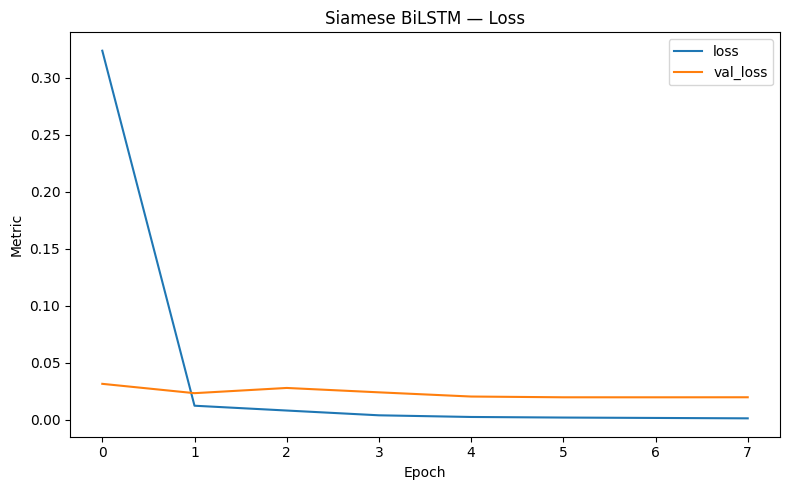

Saved: /kaggle/working/figures/bilstm_loss.png


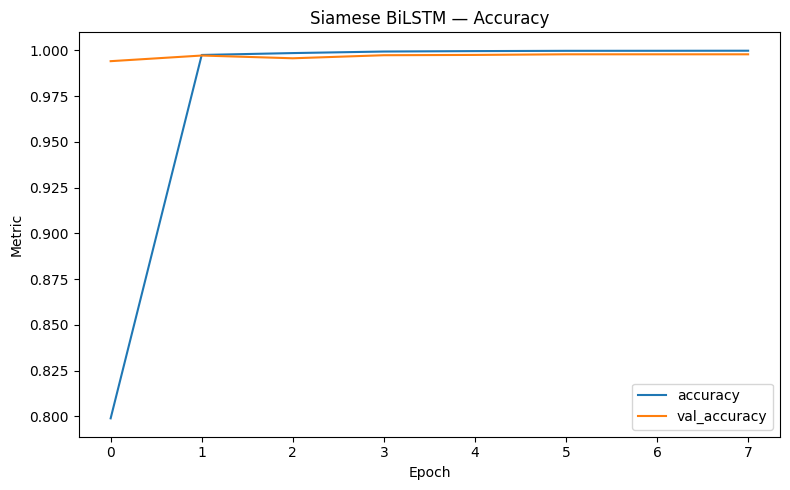

Saved: /kaggle/working/figures/bilstm_accuracy.png


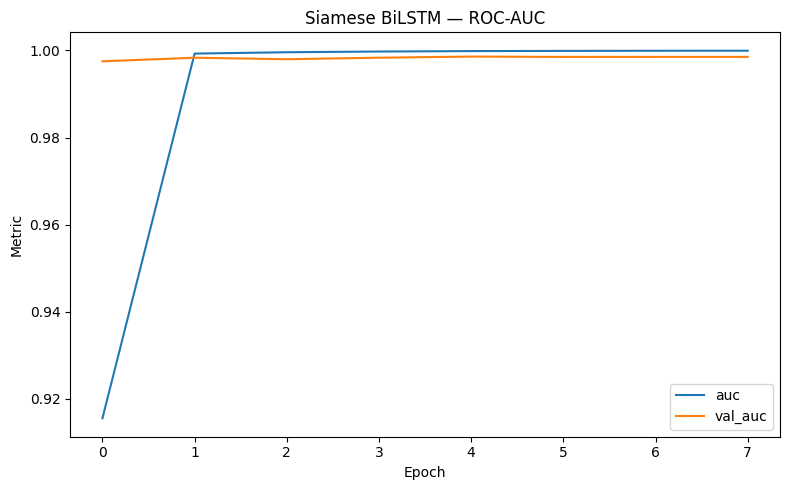

Saved: /kaggle/working/figures/bilstm_auc.png


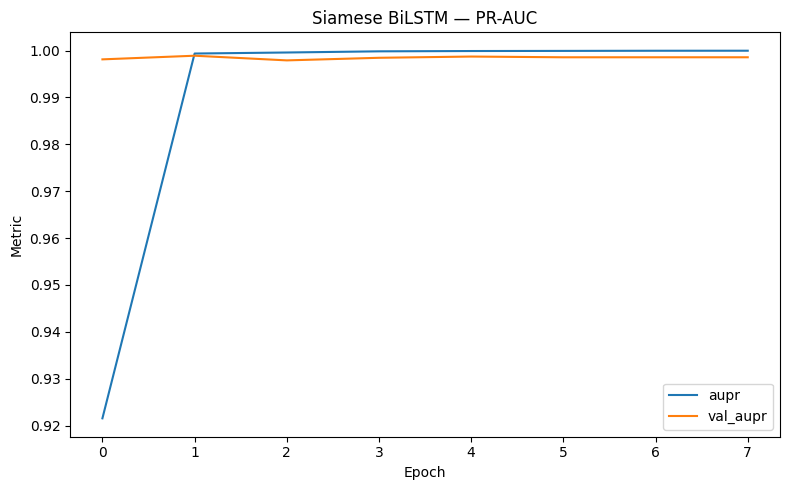

Saved: /kaggle/working/figures/bilstm_aupr.png


In [17]:
# =========================
# Cell 13: Plot Training Curves
# =========================
import matplotlib.pyplot as plt
import pandas as pd

# Load history from CSV if needed (works whether session persisted or not)
hist_csv = WORK_DIR / "bilstm_history.csv"
if hist_csv.exists():
    hist_df = pd.read_csv(hist_csv)
else:
    # Fallback from in-memory history (if available)
    hist_df = pd.DataFrame(history.history)

# Ensure columns exist
expected_cols = ["epoch","loss","accuracy","auc","aupr","val_loss","val_accuracy","val_auc","val_aupr"]
if "epoch" not in hist_df.columns:
    hist_df.insert(0, "epoch", range(len(hist_df)))

display(hist_df.tail(3))

def _save_lineplot(y_keys, title, fname):
    plt.figure(figsize=(8,5))
    for k in y_keys:
        if k in hist_df.columns:
            plt.plot(hist_df["epoch"], hist_df[k], label=k)
    plt.xlabel("Epoch")
    plt.ylabel("Metric")
    plt.title(title)
    plt.legend()
    out = FIG_DIR / fname
    plt.tight_layout()
    plt.savefig(out, dpi=160)
    plt.show()
    print("Saved:", out)

# Loss & Accuracy
_save_lineplot(["loss","val_loss"], "Siamese BiLSTM — Loss", "bilstm_loss.png")
_save_lineplot(["accuracy","val_accuracy"], "Siamese BiLSTM — Accuracy", "bilstm_accuracy.png")

# AUC (ROC) & AUPR
_save_lineplot(["auc","val_auc"], "Siamese BiLSTM — ROC-AUC", "bilstm_auc.png")
_save_lineplot(["aupr","val_aupr"], "Siamese BiLSTM — PR-AUC", "bilstm_aupr.png")


 Inference time (val+test): 3.45s
Chosen threshold (val F1-optimal): 0.100  |  val F1=0.9981

=== Baseline 1 — Siamese BiLSTM (TEST) ===
  accuracy: 0.9988
 precision: 0.9995
    recall: 0.9980
        f1: 0.9988
   roc_auc: 0.9994
    pr_auc: 0.9996
    n_test: 12000.0000
confusion: {'tn': 5976, 'fp': 3, 'fn': 12, 'tp': 6009}
Saved metrics JSON → /kaggle/working/bilstm_test_metrics.json


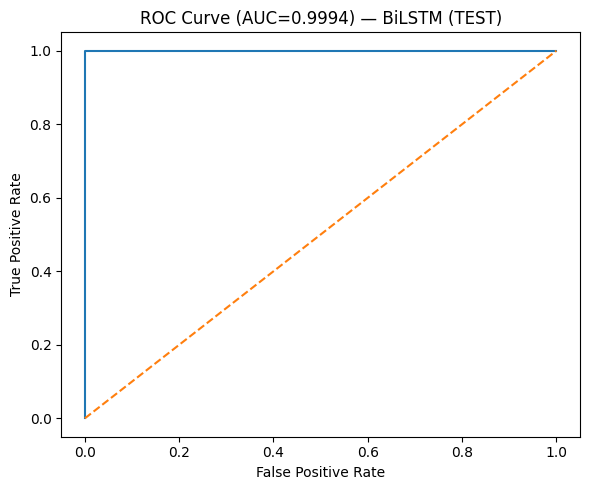

Saved: /kaggle/working/figures/bilstm_test_roc.png


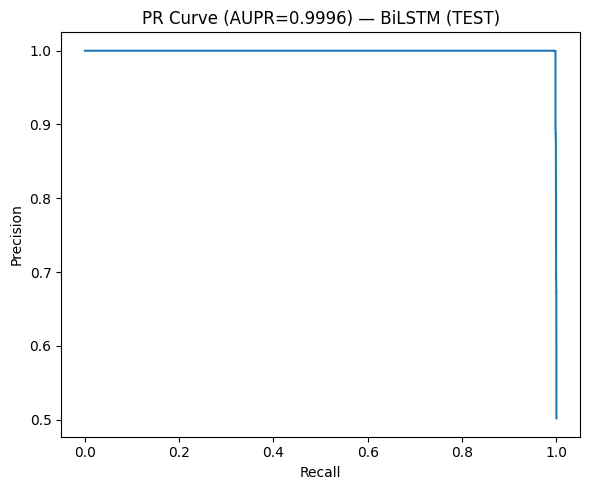

Saved: /kaggle/working/figures/bilstm_test_pr.png
Saved qualitative examples CSV → /kaggle/working/bilstm_test_qualitative_examples.csv


,case,prob,label,pred,a_cat,b_cat,a_short,b_short,a_id,b_id
0,TP,1.000000e+00,1,1,notice-of-defaults,notice-of-defaults,Notice of Defaults. If a Default occurs and is...,Notice of Defaults. If a Default occurs and is...,notice-of-defaults::271,notice-of-defaults::277
1,TP,1.000000e+00,1,1,notice-of-defaults,notice-of-defaults,Notice of Defaults. Promptly after the occurre...,Notice of Defaults. 45 SECTION 7.6 REPORTS BY ...,notice-of-defaults::251,notice-of-defaults::408
2,TP,1.000000e+00,1,1,remedies,remedies,Remedies. Immediately and without notice upon ...,Remedies. All remedies at law or in equity sha...,remedies::229,remedies::277
3,TP,1.000000e+00,1,1,registration-rights,registration-rights,Registration Rights. There are no persons with...,Registration Rights. Except as disclosed in th...,registration-rights::9,registration-rights::312
4,TP,1.000000e+00,1,1,additional-agreements,additional-agreements,Additional Agreements. Each of the parties her...,Additional Agreements. Party A agrees to compl...,additional-agreements::10,additional-agreements::11
5,TN,1.140981e-24,0,0,survival-of-representations-and-warranties,waiver-of-past-defaults,Survival of Representations and Warranties. Al...,Waiver of Past Defaults. Subject to Section 9....,survival-of-representations-and-warranties::114,waiver-of-past-defaults::191
6,TN,1.400805e-24,0,0,survival-of-representations-and-warranties,waiver-of-past-defaults,Survival of Representations and Warranties. Al...,Waiver of Past Defaults. An Event of Default p...,survival-of-representations-and-warranties::101,waiver-of-past-defaults::35
7,TN,1.990178e-24,0,0,survival-of-representations-and-warranties,waiver-of-past-defaults,Survival of Representations and Warranties. Al...,Waiver of Past Defaults. Subject to Section 6....,survival-of-representations-and-warranties::356,waiver-of-past-defaults::129


In [21]:
# =========================
# Cell 14: Evaluation — Test metrics, curves & examples (no reload)
# =========================
import time, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score,
    confusion_matrix, roc_curve, precision_recall_curve,
)

tf = lazy_import_tf()
assert tf is not None, "TensorFlow not available."
set_all_seeds(SEED)

# --- Use the in-memory trained model ---
try:
    _ = bilstm_model  # raise NameError if not defined
except NameError as e:
    raise RuntimeError("`bilstm_model` not found in memory. Re-run Cell 12 (training) first.") from e

# -------- Vectorize VAL & TEST (for threshold & metrics) --------
def vectorize_side(series):
    return vectorizer(tf.constant(series.astype(str).values)).numpy()

Xa_va = vectorize_side(pairs_val["a_text"])
Xb_va = vectorize_side(pairs_val["b_text"])
y_va  = pairs_val["label"].astype(int).values

Xa_te = vectorize_side(pairs_test["a_text"])
Xb_te = vectorize_side(pairs_test["b_text"])
y_te  = pairs_test["label"].astype(int).values

# -------- Predict probabilities --------
t0 = time.time()
p_va = bilstm_model.predict([Xa_va, Xb_va], batch_size=512, verbose=0).reshape(-1)
p_te = bilstm_model.predict([Xa_te, Xb_te], batch_size=512, verbose=0).reshape(-1)
print(f" Inference time (val+test): {time.time()-t0:.2f}s")

# -------- Choose decision threshold on VAL to maximize F1 --------
thr_grid = np.linspace(0.1, 0.9, 81)
best_thr, best_f1 = 0.5, -1.0
for thr in thr_grid:
    y_hat = (p_va >= thr).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_va, y_hat, average="binary", zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr = f1, thr
print(f"Chosen threshold (val F1-optimal): {best_thr:.3f}  |  val F1={best_f1:.4f}")

# -------- TEST metrics --------
y_pred = (p_te >= best_thr).astype(int)
acc  = accuracy_score(y_te, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="binary", zero_division=0)
roc  = roc_auc_score(y_te, p_te)
aupr = average_precision_score(y_te, p_te)
cm = confusion_matrix(y_te, y_pred)
tn, fp, fn, tp = cm.ravel()

metrics = {
    "threshold": float(best_thr),
    "test": {
        "accuracy": float(acc),
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "roc_auc": float(roc),
        "pr_auc": float(aupr),
        "cm": {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)},
        "n_test": int(len(y_te))
    }
}

print("\n=== Baseline 1 — Siamese BiLSTM (TEST) ===")
for k,v in metrics["test"].items():
    if k != "cm":
        print(f"{k:>10s}: {v:.4f}")
print("confusion:", metrics["test"]["cm"])

with open(WORK_DIR / "bilstm_test_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
print("Saved metrics JSON →", WORK_DIR / "bilstm_test_metrics.json")

# -------- Curves: ROC & PR on TEST --------
fpr, tpr, _ = roc_curve(y_te, p_te)
prec_curve, rec_curve, _ = precision_recall_curve(y_te, p_te)

plt.figure(figsize=(6,5)); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC={roc:.4f}) — BiLSTM (TEST)")
plt.tight_layout(); out_roc = FIG_DIR / "bilstm_test_roc.png"; plt.savefig(out_roc, dpi=160); plt.show(); print("Saved:", out_roc)

plt.figure(figsize=(6,5)); plt.plot(rec_curve, prec_curve)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"PR Curve (AUPR={aupr:.4f}) — BiLSTM (TEST)")
plt.tight_layout(); out_pr = FIG_DIR / "bilstm_test_pr.png"; plt.savefig(out_pr, dpi=160); plt.show(); print("Saved:", out_pr)

# -------- Qualitative examples (TP/TN/FP/FN) --------
test_df = pairs_test.copy().assign(prob=p_te, pred=y_pred)

def shorten(s, width=260):
    import textwrap as tw
    return tw.shorten(str(s), width=width, placeholder=" ...")

TP = test_df[(test_df.label==1) & (test_df.pred==1)].sort_values("prob", ascending=False).head(5)
TN = test_df[(test_df.label==0) & (test_df.pred==0)].sort_values("prob", ascending=True).head(5)
FP = test_df[(test_df.label==0) & (test_df.pred==1)].sort_values("prob", ascending=False).head(5)
FN = test_df[(test_df.label==1) & (test_df.pred==0)].sort_values("prob", ascending=True).head(5)

for df_ in [TP, TN, FP, FN]:
    df_["a_short"] = df_["a_text"].map(lambda x: shorten(x, 260))
    df_["b_short"] = df_["b_text"].map(lambda x: shorten(x, 260))

qual = pd.concat([TP.assign(case="TP"), TN.assign(case="TN"),
                  FP.assign(case="FP"), FN.assign(case="FN")], ignore_index=True)[
    ["case","prob","label","pred","a_cat","b_cat","a_short","b_short","a_id","b_id"]
]

qual_path = WORK_DIR / "bilstm_test_qualitative_examples.csv"
qual.to_csv(qual_path, index=False)
print("Saved qualitative examples CSV →", qual_path)
display(qual.head(8))


**> BASELINE 2**

In [25]:
# =========================
# Cell 16: Define Attention-based Siamese Encoder
# =========================
import tensorflow as tf
from tensorflow.keras import layers, Model, Input

def scaled_dot_attention(q, k, v):
    """Basic scaled dot-product attention"""
    attn_logits = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(
        tf.cast(tf.shape(k)[-1], tf.float32)
    )
    attn_weights = tf.nn.softmax(attn_logits, axis=-1)
    return tf.matmul(attn_weights, v)

def attention_encoder(vocab_size, embed_dim=128, gru_units=128, max_len=200):
    inp = Input(shape=(max_len,), name="text_in")
    x = layers.Embedding(vocab_size, embed_dim, mask_zero=True)(inp)
    x = layers.Bidirectional(layers.GRU(gru_units, return_sequences=True))(x)

    # Self-attention
    q = layers.Dense(gru_units, use_bias=False)(x)
    k = layers.Dense(gru_units, use_bias=False)(x)
    v = layers.Dense(gru_units, use_bias=False)(x)
    attn_out = layers.Lambda(lambda t: scaled_dot_attention(t[0], t[1], t[2]))([q, k, v])
    pooled = layers.GlobalAveragePooling1D()(attn_out)

    return Model(inp, pooled, name="attention_encoder")

def build_siamese_attention(vocab_size, embed_dim=128, gru_units=128, max_len=200):
    enc = attention_encoder(vocab_size, embed_dim, gru_units, max_len)
    a_in = Input(shape=(max_len,), name="input_a")
    b_in = Input(shape=(max_len,), name="input_b")

    a_vec, b_vec = enc(a_in), enc(b_in)
    diff = tf.abs(a_vec - b_vec)
    mult = a_vec * b_vec
    x = layers.Concatenate()([diff, mult])
    x = layers.Dense(128, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(64, activation="relu")(x)
    out = layers.Dense(1, activation="sigmoid")(x)

    model = Model([a_in, b_in], out, name="Siamese_AttentionEncoder")
    return model

print(" Defined Attention-based Siamese Encoder")


✅ Defined Attention-based Siamese Encoder


In [27]:
# =========================
# Cell 17 (fixed): Attention Encoder re-def, build, compile, summary
# =========================
import tensorflow as tf
from tensorflow.keras import layers, Model, Input
from tensorflow import keras
from tensorflow.keras import backend as K

tf = lazy_import_tf()
assert tf is not None, "TensorFlow not available."
set_all_seeds(SEED)

VOCAB_SIZE = min(MAX_TOKENS, len(vectorizer.get_vocabulary()))
EMBED_DIM  = 128
GRU_UNITS  = 128
MAXLEN     = MAX_LEN

class SelfAttention(layers.Layer):
    """Single-head scaled dot-product self-attention."""
    def __init__(self, d_model, **kwargs):
        super().__init__(**kwargs)
        self.wq = layers.Dense(d_model, use_bias=False)
        self.wk = layers.Dense(d_model, use_bias=False)
        self.wv = layers.Dense(d_model, use_bias=False)

    def call(self, x):
        # x: (batch, seq, feat)
        q = self.wq(x)
        k = self.wk(x)
        v = self.wv(x)
        dk = tf.cast(tf.shape(k)[-1], tf.float32)
        scores = tf.matmul(q, k, transpose_b=True) / tf.math.sqrt(dk)  # (b, L, L)
        weights = tf.nn.softmax(scores, axis=-1)
        return tf.matmul(weights, v)  # (b, L, d_model)

def attention_encoder(vocab_size, embed_dim=128, gru_units=128, max_len=200):
    inp = Input(shape=(max_len,), name="text_in")
    # mask_zero=False to avoid mask propagation issues through custom attention
    x = layers.Embedding(vocab_size, embed_dim, mask_zero=False, name="embedding")(inp)
    x = layers.Bidirectional(layers.GRU(gru_units, return_sequences=True), name="bigru")(x)
    x = SelfAttention(gru_units, name="self_attention")(x)
    x = layers.GlobalAveragePooling1D(name="gap")(x)
    x = layers.Dense(128, activation="relu", name="proj")(x)
    return Model(inp, x, name="attention_encoder")

def build_siamese_attention(vocab_size, embed_dim=128, gru_units=128, max_len=200):
    enc = attention_encoder(vocab_size, embed_dim, gru_units, max_len)

    a_in = Input(shape=(max_len,), name="input_a")
    b_in = Input(shape=(max_len,), name="input_b")

    a_vec = enc(a_in)
    b_vec = enc(b_in)

    # Use Keras layers/ops (Keras 3 safe) for merge features
    diff = layers.Subtract(name="diff")([a_vec, b_vec])
    diff = layers.Lambda(lambda t: tf.abs(t), name="abs_diff")(diff)
    mult = layers.Multiply(name="elem_mult")([a_vec, b_vec])

    x = layers.Concatenate(name="merge")([diff, mult])
    x = layers.Dense(128, activation="relu", name="fc1")(x)
    x = layers.Dropout(0.2, name="drop1")(x)
    x = layers.Dense(64, activation="relu", name="fc2")(x)
    out = layers.Dense(1, activation="sigmoid", name="out")(x)

    return Model([a_in, b_in], out, name="Siamese_AttentionEncoder")

attn_model = build_siamese_attention(
    vocab_size=VOCAB_SIZE,
    embed_dim=EMBED_DIM,
    gru_units=GRU_UNITS,
    max_len=MAXLEN
)

attn_model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        "accuracy",
        tf.keras.metrics.AUC(name="auc", curve="ROC"),
        tf.keras.metrics.AUC(name="aupr", curve="PR"),
    ],
)

attn_model.summary(line_length=120, show_trainable=True)

# Save minimal config for the report
attn_cfg = {
    "model": "Siamese_AttentionEncoder",
    "vocab_size": int(VOCAB_SIZE),
    "embed_dim": int(EMBED_DIM),
    "gru_units": int(GRU_UNITS),
    "max_len": int(MAXLEN),
    "optimizer": "Adam(1e-3)",
    "loss": "binary_crossentropy",
    "metrics": ["accuracy", "AUC(ROC)", "AUC(PR)"],
}
cfg_path = WORK_DIR / "attn_config.json"
with open(cfg_path, "w") as f:
    json.dump(attn_cfg, f, indent=2)
print("Saved attention model config to:", cfg_path)


Model: "Siamese_AttentionEncoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━
┃ Layer (type)                  ┃ Output Shape              ┃          Param # ┃ Connected to              ┃ Traina
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━
│ input_a (InputLayer)          │ (None, 200)               │                0 │ -                         │     - 
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ input_b (InputLayer)          │ (None, 200)               │                0 │ -                         │     - 
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ attention_encoder             │ (None, 128)               │        5,432,960 │ input_a[0][0],            │     Y 
│ (Functional)                  │                           │                  │ input_b[0][0]             │       
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ diff (Subtract)               │ (None, 128)               │                0 │ attention_encoder[0][0],  │     - 
│                               │                           │                  │ attention_encoder[1][0]   │       
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ abs_diff (Lambda)             │ (None, 128)               │                0 │ diff[0][0]                │     - 
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ elem_mult (Multiply)          │ (None, 128)               │                0 │ attention_encoder[0][0],  │     - 
│                               │                           │                  │ attention_encoder[1][0]   │       
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ merge (Concatenate)           │ (None, 256)               │                0 │ abs_diff[0][0],           │     - 
│                               │                           │                  │ elem_mult[0][0]           │       
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ fc1 (Dense)                   │ (None, 128)               │           32,896 │ merge[0][0]               │     Y 
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ drop1 (Dropout)               │ (None, 128)               │                0 │ fc1[0][0]                 │     - 
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ fc2 (Dense)                   │ (None, 64)                │            8,256 │ drop1[0][0]               │     Y 
├───────────────────────────────┼───────────────────────────┼──────────────────┼───────────────────────────┼───────
│ out (Dense)                   │ (None, 1)                 │               65 │ fc2[0][0]                 │     Y 
└───────────────────────────────┴───────────────────────────┴──────────────────┴───────────────────────────┴───────

 Total params: 5,474,177 (20.88 MB)

 Trainable params: 5,474,177 (20.88 MB)

 Non-trainable params: 0 (0.00 B)

Saved attention model config to: /kaggle/working/attn_config.json


In [28]:
# =========================
# Cell 18: Train Siamese Attention Encoder
# =========================
import time

tf = lazy_import_tf()
assert tf is not None, "TensorFlow not available."
set_all_seeds(SEED)

# Reuse already-vectorized tensors if present; otherwise vectorize.
def vectorize_side(series):
    return vectorizer(tf.constant(series.astype(str).values)).numpy()

try:
    Xa_tr, Xb_tr, y_tr
    Xa_va, Xb_va, y_va
except NameError:
    print("Vectorizing train/val pairs (attention baseline)...")
    Xa_tr = vectorize_side(pairs_train["a_text"])
    Xb_tr = vectorize_side(pairs_train["b_text"])
    y_tr  = pairs_train["label"].astype("float32").values

    Xa_va = vectorize_side(pairs_val["a_text"])
    Xb_va = vectorize_side(pairs_val["b_text"])
    y_va  = pairs_val["label"].astype("float32").values

print("Shapes:",
      "\n  Xa_tr", Xa_tr.shape, "Xb_tr", Xb_tr.shape, "y_tr", y_tr.shape,
      "\n  Xa_va", Xa_va.shape, "Xb_va", Xb_va.shape, "y_va", y_va.shape)

# tf.data pipelines
BATCH_SIZE = 256
train_ds = tf.data.Dataset.from_tensor_slices(((Xa_tr, Xb_tr), y_tr))\
    .shuffle(10_000, seed=SEED, reshuffle_each_iteration=True)\
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices(((Xa_va, Xb_va), y_va))\
    .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Callbacks: use distinct file names for this baseline
ckpt_path = WORK_DIR / "attn_best.keras"
csv_log   = WORK_DIR / "attn_history.csv"

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath=str(ckpt_path),
        save_best_only=True,
        monitor="val_auc",
        mode="max",
        verbose=1
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_auc",
        mode="max",
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_auc",
        mode="max",
        factor=0.5,
        patience=1,
        min_lr=1e-5,
        verbose=1
    ),
    tf.keras.callbacks.CSVLogger(str(csv_log))
]

# Train
EPOCHS = 12
print("Starting training (Attention Encoder)...")
t0 = time.time()
history_attn = attn_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)
t_train_attn = time.time() - t0
print(f"Training time (Attention): {t_train_attn/60:.1f} min")

# Save final model
final_model_path = WORK_DIR / "attn_final.keras"
attn_model.save(str(final_model_path))
print("Saved best weights to:", ckpt_path)
print("Saved final model to :", final_model_path)

# Quick summary of final epoch metrics
hist = history_attn.history
print("\nFinal epoch metrics (Attention):")
for k in ["loss","accuracy","auc","aupr","val_loss","val_accuracy","val_auc","val_aupr"]:
    if k in hist:
        print(f"  {k:>12s}: {hist[k][-1]:.4f}")


Shapes: 
  Xa_tr (100000, 200) Xb_tr (100000, 200) y_tr (100000,) 
  Xa_va (12000, 200) Xb_va (12000, 200) y_va (12000,)
Starting training (Attention Encoder)...
Epoch 1/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7067 - auc: 0.7841 - aupr: 0.7875 - loss: 0.4557
Epoch 1: val_auc improved from -inf to 0.99950, saving model to /kaggle/working/attn_best.keras
391/391 ━━━━━━━━━━━━━━━━━━━━ 61s 146ms/step - accuracy: 0.7071 - auc: 0.7846 - aupr: 0.7879 - loss: 0.4551 - val_accuracy: 0.9980 - val_auc: 0.9995 - val_aupr: 0.9997 - val_loss: 0.0099 - learning_rate: 0.0010
Epoch 2/12
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.9992 - auc: 0.9997 - aupr: 0.9998 - loss: 0.0045
Epoch 2: val_auc did not improve from 0.99950

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
391/391 ━━━━━━━━━━━━━━━━━━━━ 55s 141ms/step - accuracy: 0.9992 - auc: 0.9997 - aupr: 0.9998 - loss: 0.0045 - val_accuracy: 0.9975 - val_auc: 0.9993 - val_aupr: 0.9995 - val_lo

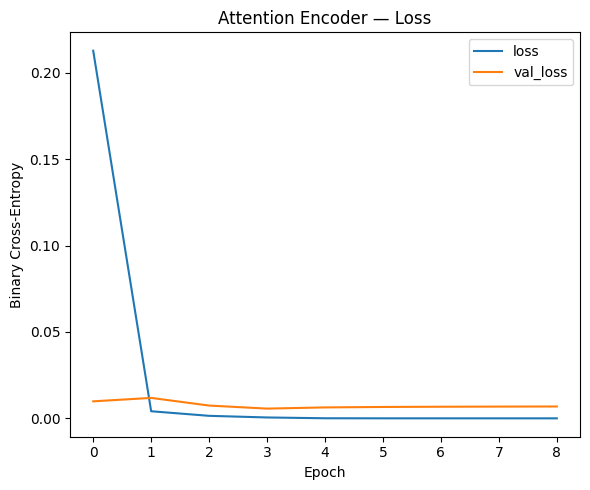

Saved: /kaggle/working/figures/attn_loss.png


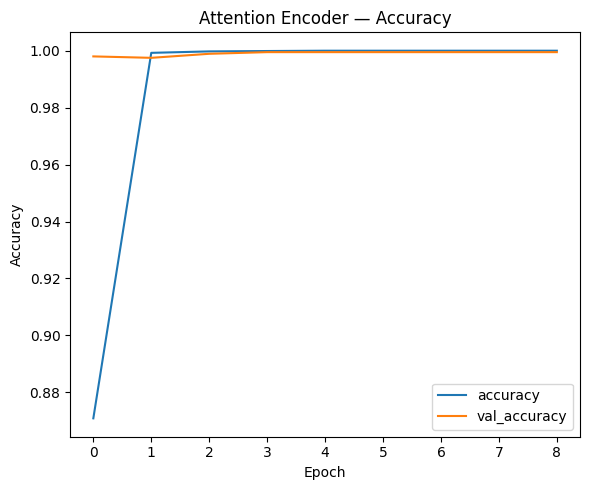

Saved: /kaggle/working/figures/attn_accuracy.png


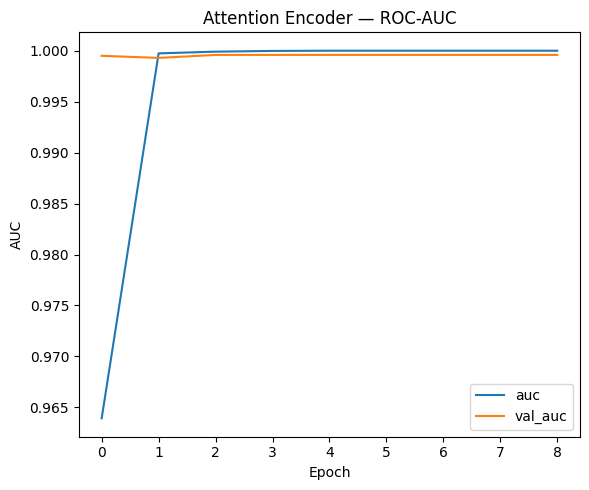

Saved: /kaggle/working/figures/attn_auc.png


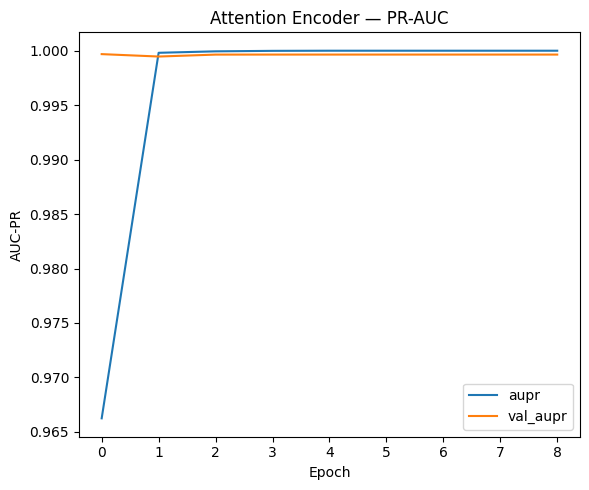

Saved: /kaggle/working/figures/attn_aupr.png


In [29]:
# =========================
# Cell 19: Training curves — Attention Encoder
# =========================
import pandas as pd
import matplotlib.pyplot as plt

hist_csv = WORK_DIR / "attn_history.csv"
FIG_DIR.mkdir(exist_ok=True)

# Load history from CSV (callback) or fall back to in-memory object
if hist_csv.exists():
    H = pd.read_csv(hist_csv)
else:
    assert "history_attn" in globals(), "No history found. Re-run Cell 18."
    H = pd.DataFrame(history_attn.history)
    H.insert(0, "epoch", range(1, len(H)+1))

def _plot(ykeys, title, outfile, ylabel=None):
    plt.figure(figsize=(6,5))
    for k in ykeys:
        if k in H.columns:
            plt.plot(H["epoch"], H[k], label=k)
    plt.xlabel("Epoch")
    plt.ylabel(ylabel or "Value")
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.savefig(outfile, dpi=160)
    plt.show()
    print("Saved:", outfile)

_plot(["loss", "val_loss"], "Attention Encoder — Loss", FIG_DIR / "attn_loss.png", ylabel="Binary Cross-Entropy")
_plot(["accuracy", "val_accuracy"], "Attention Encoder — Accuracy", FIG_DIR / "attn_accuracy.png", ylabel="Accuracy")
_plot(["auc", "val_auc"], "Attention Encoder — ROC-AUC", FIG_DIR / "attn_auc.png", ylabel="AUC")
_plot(["aupr", "val_aupr"], "Attention Encoder — PR-AUC", FIG_DIR / "attn_aupr.png", ylabel="AUC-PR")


Inference time (val+test): 5.04s
Chosen threshold (val F1-optimal): 0.100  |  val F1=0.9995

=== Baseline 2 — Attention Encoder (TEST) ===
  accuracy: 0.9994
 precision: 0.9998
    recall: 0.9990
        f1: 0.9994
   roc_auc: 0.9999
    pr_auc: 0.9998
    n_test: 12000.0000
confusion: {'tn': 5978, 'fp': 1, 'fn': 6, 'tp': 6015}
Saved metrics JSON → /kaggle/working/attn_test_metrics.json


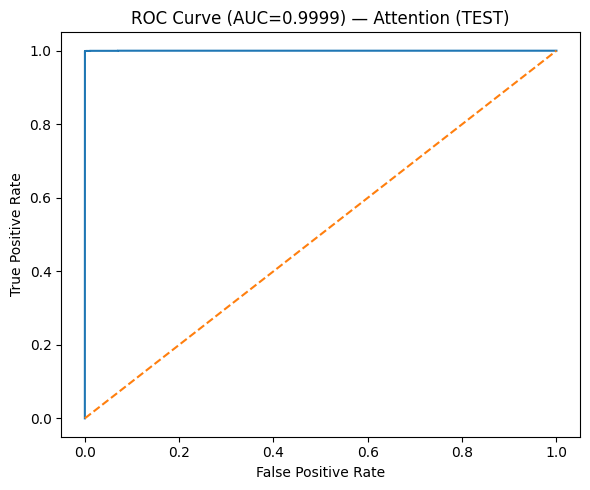

Saved: /kaggle/working/figures/attn_test_roc.png


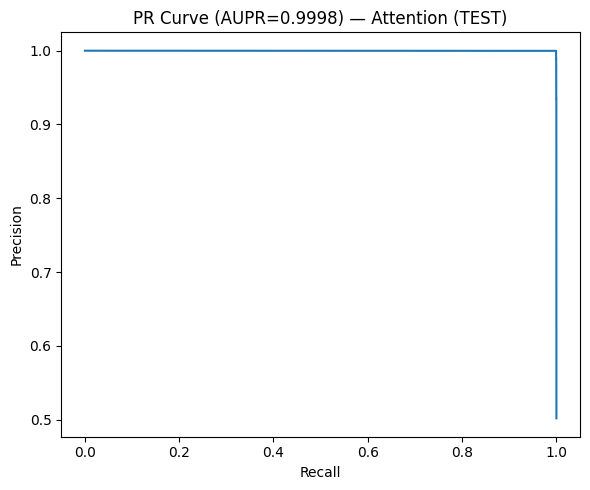

Saved: /kaggle/working/figures/attn_test_pr.png
Saved qualitative examples CSV → /kaggle/working/attn_test_qualitative_examples.csv


,case,prob,label,pred,a_cat,b_cat,a_short,b_short,a_id,b_id
0,TP,1.000000e+00,1,1,warranties,warranties,Warranties. Contractor unconditionally warrant...,Warranties. For any construction or installati...,warranties::86,warranties::377
1,TP,1.000000e+00,1,1,reimbursement,reimbursement,Reimbursement. If an Issuing Bank shall make a...,Reimbursement. (a) If the Issuing Lender shall...,reimbursement::11,reimbursement::148
2,TP,1.000000e+00,1,1,financial-information,financial-information,Financial Information. Lessee will furnish to ...,Financial Information. From and after the date...,financial-information::132,financial-information::222
3,TP,1.000000e+00,1,1,notice-of-defaults,notice-of-defaults,Notice of Defaults. Promptly after the occurre...,Notice of Defaults. 45 SECTION 7.6 REPORTS BY ...,notice-of-defaults::251,notice-of-defaults::408
4,TP,1.000000e+00,1,1,notification,notification,Notification. The Agent shall promptly notify ...,Notification. Once during each membership year...,notification::141,notification::271
5,TN,5.026171e-15,0,0,environmental-laws,event-of-default,Environmental Laws. See Section 6.20(a).,Event of Default. Any of the following events ...,environmental-laws::314,event-of-default::461
6,TN,5.149604e-15,0,0,environmental-laws,event-of-default,Environmental Laws. See Section 6.20(a).,Event of Default. Any one of the conditions or...,environmental-laws::314,event-of-default::31
7,TN,5.163708e-15,0,0,environmental-laws,event-of-default,"Environmental Laws. Except as would not, singl...",Event of Default. No Event of Default or Unmat...,environmental-laws::21,event-of-default::57


In [30]:
# =========================
# Cell 20: Evaluate Attention Encoder on TEST
# =========================
import time, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, average_precision_score,
    confusion_matrix, roc_curve, precision_recall_curve,
)

tf = lazy_import_tf()
assert tf is not None, "TensorFlow not available."
set_all_seeds(SEED)

# Use the in-memory trained attention model
try:
    _ = attn_model
except NameError as e:
    raise RuntimeError("`attn_model` not found in memory. Re-run Cell 18 (training) first.") from e

def vectorize_side(series):
    return vectorizer(tf.constant(series.astype(str).values)).numpy()

# Vectorize VAL and TEST
Xa_va = vectorize_side(pairs_val["a_text"])
Xb_va = vectorize_side(pairs_val["b_text"])
y_va  = pairs_val["label"].astype(int).values

Xa_te = vectorize_side(pairs_test["a_text"])
Xb_te = vectorize_side(pairs_test["b_text"])
y_te  = pairs_test["label"].astype(int).values

# Predict probabilities
t0 = time.time()
p_va = attn_model.predict([Xa_va, Xb_va], batch_size=512, verbose=0).reshape(-1)
p_te = attn_model.predict([Xa_te, Xb_te], batch_size=512, verbose=0).reshape(-1)
print(f"Inference time (val+test): {time.time()-t0:.2f}s")

# Choose decision threshold on VAL to maximize F1
thr_grid = np.linspace(0.1, 0.9, 81)
best_thr, best_f1 = 0.5, -1.0
for thr in thr_grid:
    y_hat = (p_va >= thr).astype(int)
    _, _, f1, _ = precision_recall_fscore_support(y_va, y_hat, average="binary", zero_division=0)
    if f1 > best_f1:
        best_f1, best_thr = f1, thr
print(f"Chosen threshold (val F1-optimal): {best_thr:.3f}  |  val F1={best_f1:.4f}")

# TEST metrics
y_pred = (p_te >= best_thr).astype(int)
acc  = accuracy_score(y_te, y_pred)
prec, rec, f1, _ = precision_recall_fscore_support(y_te, y_pred, average="binary", zero_division=0)
roc  = roc_auc_score(y_te, p_te)
aupr = average_precision_score(y_te, p_te)
cm = confusion_matrix(y_te, y_pred)
tn, fp, fn, tp = cm.ravel()

metrics = {
    "threshold": float(best_thr),
    "test": {
        "accuracy": float(acc),
        "precision": float(prec),
        "recall": float(rec),
        "f1": float(f1),
        "roc_auc": float(roc),
        "pr_auc": float(aupr),
        "cm": {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp)},
        "n_test": int(len(y_te))
    }
}

print("\n=== Baseline 2 — Attention Encoder (TEST) ===")
for k,v in metrics["test"].items():
    if k != "cm":
        print(f"{k:>10s}: {v:.4f}")
print("confusion:", metrics["test"]["cm"])

# Save metrics JSON
out_json = WORK_DIR / "attn_test_metrics.json"
with open(out_json, "w") as f:
    json.dump(metrics, f, indent=2)
print("Saved metrics JSON →", out_json)

# ROC & PR curves (TEST)
fpr, tpr, _ = roc_curve(y_te, p_te)
prec_curve, rec_curve, _ = precision_recall_curve(y_te, p_te)

plt.figure(figsize=(6,5)); plt.plot(fpr, tpr); plt.plot([0,1],[0,1],'--')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (AUC={roc:.4f}) — Attention (TEST)")
plt.tight_layout(); out_roc = FIG_DIR / "attn_test_roc.png"; plt.savefig(out_roc, dpi=160); plt.show(); print("Saved:", out_roc)

plt.figure(figsize=(6,5)); plt.plot(rec_curve, prec_curve)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title(f"PR Curve (AUPR={aupr:.4f}) — Attention (TEST)")
plt.tight_layout(); out_pr = FIG_DIR / "attn_test_pr.png"; plt.savefig(out_pr, dpi=160); plt.show(); print("Saved:", out_pr)

# Qualitative examples (TP/TN/FP/FN)
test_df = pairs_test.copy().assign(prob=p_te, pred=y_pred)

def shorten(s, width=260):
    import textwrap as tw
    return tw.shorten(str(s), width=width, placeholder=" ...")

TP = test_df[(test_df.label==1) & (test_df.pred==1)].sort_values("prob", ascending=False).head(5)
TN = test_df[(test_df.label==0) & (test_df.pred==0)].sort_values("prob", ascending=True).head(5)
FP = test_df[(test_df.label==0) & (test_df.pred==1)].sort_values("prob", ascending=False).head(5)
FN = test_df[(test_df.label==1) & (test_df.pred==0)].sort_values("prob", ascending=True).head(5)

for df_ in [TP, TN, FP, FN]:
    df_["a_short"] = df_["a_text"].map(lambda x: shorten(x, 260))
    df_["b_short"] = df_["b_text"].map(lambda x: shorten(x, 260))

qual = pd.concat([TP.assign(case="TP"), TN.assign(case="TN"),
                  FP.assign(case="FP"), FN.assign(case="FN")], ignore_index=True)[
    ["case","prob","label","pred","a_cat","b_cat","a_short","b_short","a_id","b_id"]
]

qual_path = WORK_DIR / "attn_test_qualitative_examples.csv"
qual.to_csv(qual_path, index=False)
print("Saved qualitative examples CSV →", qual_path)
display(qual.head(8))
